# Problem 6 - Phase Identification(2)

## Agenda
- Problem Description
- Problem Implementation
- Wrap-Up

## Problem Description
- <b>Consider $N$ customers whose connection phase assumes one out of three possible labels $a$, $b$, or $c$ and estimate the correct customer-to-label assignment based on $M$ readings whose per-phase values are a function of the corresponding phase-connected individual customer reading.

Considered network
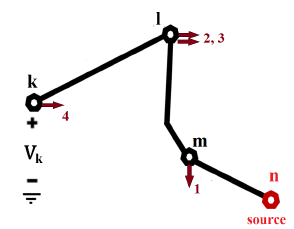

<b>Import Python Libraries

In [381]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Parameters

In [382]:
cosPhi=0.95
time=48
m=12
netFactor=0.25
noiseFactor=0.00

<b>Initial data

In [383]:
#Consumption dataset
s=  [[0.0450,    0.0150,    0.0470,    0.0330],
     [0.0250,    0.0150,    0.2480,    0.0330],
     [0.0970,    0.0250,    0.3940,    0.0330],
     [0.0700,    0.0490,    0.0200,    0.4850],
     [0.1250,    0.0460,    0.0160,    0.1430],
     [0.2900,    0.0270,    0.0160,    0.0470],
     [0.2590,    0.0150,    0.0170,    0.0200],
     [0.2590,    0.0160,    0.0280,    0.0160],
     [0.4420,    0.0160,    0.0500,    0.0170],
     [0.2010,    0.0230,    0.0460,    0.0160],
     [0.2060,    0.0490,    0.0220,    0.0240],
     [0.1300,    0.0470,    0.0160,    0.0490],
     [0.0460,    0.0260,    0.0170,    0.0480]]
s = np.array(s)

#topology
topo=[[1, 2],[2,3],[3,4]]
nBUS=np.max(topo)

#Impedance
# z = [z_nm, z_ml, z_lk]
z=np.multiply([complex(0.1,0.05),complex(0.15,0.07),complex(0.2,0.1)],netFactor)

vr=1 #Reference voltage
el=1
ni=20 #Iterations for the Power Flow




<b>Power Flow Function

In [384]:
def pf3ph(t,z,si,vr,el,ni,al):
    #Matrices creation
    t=np.array(t)
    p=t[:,0]
    f=t[:,1]
    w=len(p)+1
    vp=np.zeros((nBUS-1,w), dtype=complex)
    vn=np.zeros((nBUS-1,w), dtype=complex)
    vp[0,0:w]=vr
    
    for h in range (2,nBUS):
        vp[h-1,:]=vp[h-2,:]*al  #Create a three phase system of voltages
                                #Voltages will be the same in all BUS
   
    va=vp-vn                                                      #Auxiliar voltage
    ia=np.conj(np.divide(np.multiply(si,np.abs(va)**el),va))      #Auxiliar current 
    
    for it in range(ni):                                          #Iterations of Power Flow
        va=vp-vn
        ip=np.conj(np.divide(np.multiply(si,np.abs(va)**el),va))  #Phase current 
        inn=-np.sum(ip,0)                                         #Neutral current 
        for k in range(w-1,0,-1):                                 #Backward Cycle
            n=f[k-1]
            m=p[k-1]
            ip[:,m-1]=ip[:,m-1]+ip[:,n-1]                         #Phase Current
            inn=-np.sum(ip,0)                                     #Neutral Current

        eps= np.linalg.norm(np.max(np.abs(ia-ip),0))              #Error, comparing the new currents and the old ones (previous iteration)

        if eps>1e-4:
            ia=ip
            mvp=0
            mvn=0
            eps=np.inf
        else:                       #If the error is lower than the limit, we can return the results 
            mvp=(vp-vn)             #Phase Voltages to return
            mvn=vn[0,:]             #Neutral Voltage to return
#            return mvp, mvn, eps, ip, inn;
            return mvp;
        for k in range (w-1):                     #Forward Cycle
            n=f[k]                                
            m=p[k]
            vn[:,n-1]=vn[:,m-1]-z[k]*inn[n-1]     #Neutral Voltage 
            vp[:,n-1]=vp[:,m-1]-z[k]*ip[:,n-1]    #Phase Voltage
        ia=ip             #Save the current of previous iteration


<b> Compute the values of voltages obtained by PMUs

In [385]:
#Creation of Matrices
al=np.exp(np.multiply(np.multiply(complex(0,-1),2/3),np.pi)) #Phase Angle
Y=np.zeros((3*m), dtype=complex)
X=np.zeros((3*m,m), dtype=complex)
v=np.zeros((m,3))
dv_abs=np.zeros((m,3))


for i in range(m):
    si=[[0, 0, s[i,2], 0],[0, 0, s[i,1], 0],[0, s[i,0],  0, s[i,3]]] #Connection of consumers by
                                                                     #node and by phase
                                                                     #Consumer 1 (s[i,0]) is 
                                                                     #connected to Bus 2 in Phase 3
    mvp=pf3ph(topo,z,si,vr,el,ni,al)
    noise=1+noiseFactor*np.random.randn(3)
    mvp[:,3]=np.multiply(mvp[:,3],noise)                       #Add noise to the voltages
    Y[3*(i):3*(i)+3]=mvp[:,3]                                  #Save the voltages in matrix Y
    dv_abs[i,:]=vr-np.abs(mvp[:,3])                            #Voltage variations (only to plot)

Volt=np.reshape(Y,(m,3))   
### these are the V_measured that we want
print ('The voltages measured in the PMUs are:\n',Volt)


The voltages measured in the PMUs are:
 [[ 0.99866484-0.00476962j -0.49831414-0.86835917j -0.49392011+0.85964588j]
 [ 0.97290228-0.01601085j -0.51139766-0.87380016j -0.50744349+0.85456696j]
 [ 0.95608633-0.02441701j -0.51885398-0.87750207j -0.51325967+0.84910673j]
 [ 1.04767033-0.03551787j -0.45091668-0.89757332j -0.40102796+0.79332501j]
 [ 1.01576499-0.00999985j -0.48302166-0.87236861j -0.46567302+0.84426734j]
 [ 1.00968654-0.00695356j -0.48918564-0.87063669j -0.47774451+0.85167455j]
 [ 1.00602188-0.005418j   -0.49284148-0.869901j   -0.48483326+0.85566688j]
 [ 1.00423842-0.00571336j -0.4939299 -0.86980129j -0.48633757+0.85598497j]
 [ 1.00578779-0.00995392j -0.4910006 -0.87340185j -0.4790803 +0.84942259j]
 [ 1.0006834 -0.00538471j -0.49631931-0.86845387j -0.49010362+0.8577634j ]
 [ 1.00475844-0.00282624j -0.4936193 -0.86480633j -0.48660002+0.8589564j ]
 [ 1.00631448-0.00319825j -0.49244873-0.86549546j -0.48460471+0.85781421j]]


<b> Sum of Impedences
    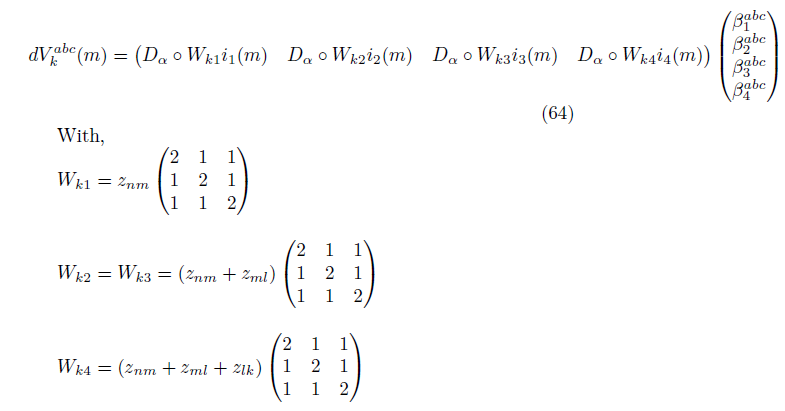

In [386]:
#The value of Z is the multiplication between D and W but not considering the values of z_nm;z_ml and z_lk
Z=[[2, al, al**2],[1, 2*al, al**2],[1, al, 2*al**2]]
Z=np.array(Z)

<b>Complex Expansion

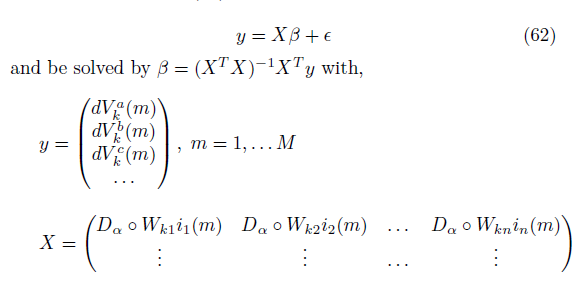

In [387]:

vz=np.zeros(3*m, dtype=complex)
vz_abs=np.zeros(3*m, dtype=complex)

#Compute dVk for each time period m   
#dvk is the yk vector in the paper (Please use the value Y)
for i in range (m):
    vz[3*(i):3*(i)+3]= np.multiply(vr,[1, al, al**2] ) -  Y[3*(i):3*(i)+3]    #With PMUs info
    vz_abs[3*(i):3*(i)+3]=np.multiply(vr-np.absolute(Y[3*(i):3*(i)+3]),[1, al, al**2])   #With RTUs info


# Compute X matrix considering different W (Please use the value Z)


X=np.zeros((3*m,m), dtype=complex)
for i in range(m):
    X[3 * i: 3 * i + 3, :3] = Z * s[i, 0]
    X[3 * i: 3 * i + 3, 3:6] = Z * s[i, 1]
    X[3 * i: 3 * i + 3, 6:9] = Z * s[i, 2]
    X[3 * i: 3 * i + 3, 9:12] = Z * s[i, 3]
    
# finally multiplying by z_nm, z_ml and z_lk
X[:,0:3]*=z[0]
X[:,3:6]*=z[0]+z[1]
X[:,6:9]*=z[0]+z[1]
X[:,9:12]*=z[0]+z[1]+z[2]




In [388]:
import matplotlib.ticker as ticker


def barplot_betas(betas, title, log):
    # create a dataframe with the betas
    df = pd.DataFrame(betas.reshape(-1,3), columns=["A", "B", "C"])
    # create a barplot
    ax = df.plot.bar(rot=0, figsize=(10,5), title=title)
    # set the xticks to the consumer number
    ax.set_xticklabels([i+1 for i in range(len(df))])
    # set the y label to the betas
    ax.set_ylabel("Beta")
    # set the x label to the consumer number
    ax.set_xlabel("Consumer")
    # if log=True, set the y scale to symlog with a minimum value of the minimum beta
    if log:
        min_beta = df.min().min()
        ax.set_yscale("symlog", linthresh=0.00001, linscale=0.5)
        ax.set_ylim([min_beta, None])
        # set the y-axis ticks formatter
        def format_y_axis(x, pos):
            if x == 1:
                return "1.00"
            elif x == -1:
                return "-1.00"
            elif x == 0:
                return "0.00"
            else:
                return f"{x:.0e}"
        ax.yaxis.set_major_formatter(format_y_axis)
    # show the plot
    plt.show()


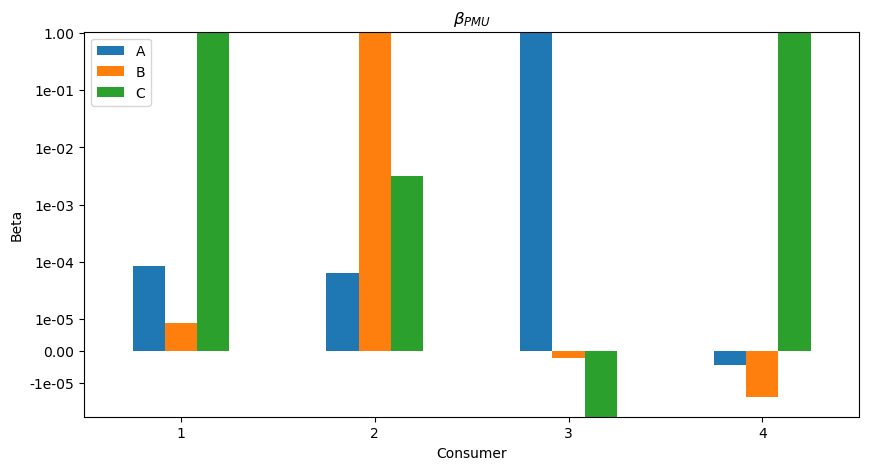

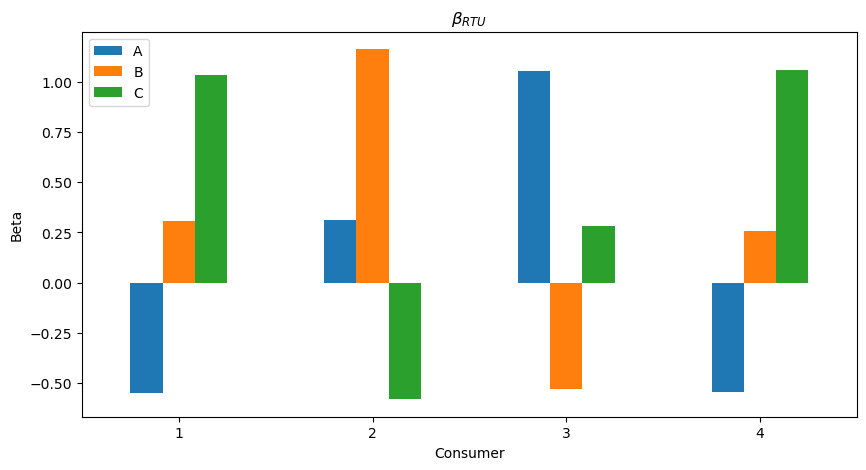

The phases of the consumers are:
PMU:  ['c', 'b', 'a', 'c']
RTU:  ['c', 'b', 'a', 'c']


In [389]:
def numb_to_letter(num):
    return chr(num + 96)

# summing up the beta computation process in a function
def compute_betas(X, vz):
    # compute the betas
    B = np.linalg.inv(X.T @ X) @ X.T @ vz
    # take the real part of the betas
    B_real = np.real(B)
    return B_real

def compute_betas_ridge(X, vz, alpha):
    B = np.linalg.inv(X.T @ X + alpha * np.identity(X.shape[1])) @ X.T @ vz
    B_real = np.real(B)
    return B_real


# summing up the phase extraction from the betas in a function
def extract_phases(B_real):
    # find the phase of each consumer
    list_phases = []
    for i in range(len(B_real)//3):
        # person_phase will be the index of the closeset value to 1 out of the three phases, from 1 to 3
        person_phase = np.argmin(np.abs(B_real[3*i:3*i+3]-1)) + 1
        # convert the index to the letter of the phase
        phase = numb_to_letter(person_phase)
        # append the phase to the list
        list_phases.append(phase)
    return list_phases


def summarize_phase_id(X,vz,vz_abs):
    Bpmu_real = compute_betas(X, vz)
    Brtu_real = compute_betas(X, vz_abs)
    list_phases_pmu = extract_phases(Bpmu_real)
    list_phases_rtu= extract_phases(Brtu_real)
    # barplot the betas
    barplot_betas(Bpmu_real, r"$\beta_{PMU}$", True)
    barplot_betas(Brtu_real, r"$\beta_{RTU}$", False)
    # print the phases as lists
    print("The phases of the consumers are:")
    print("PMU: ",list_phases_pmu)
    print("RTU: ",list_phases_rtu)

# adding option to use the ridge regression
def summarize_phase_id_ridge(X,vz,vz_abs,alpha):
    Bpmu_real = compute_betas_ridge(X, vz,alpha)
    Brtu_real = compute_betas_ridge(X, vz_abs,alpha)
    list_phases_pmu = extract_phases(Bpmu_real)
    list_phases_rtu= extract_phases(Brtu_real)
    # barplot the betas
    barplot_betas(Bpmu_real, r"$\beta_{PMU}$", True)
    barplot_betas(Brtu_real, r"$\beta_{RTU}$", False)
    # print the phases as lists
    print("The phases of the consumers are:")
    print("PMU: ",list_phases_pmu)
    print("RTU: ",list_phases_rtu)


# shapes of vz, X, beta
# (36,) (36, 12) (12,)
    

summarize_phase_id(X,vz,vz_abs)

<b>Graphics

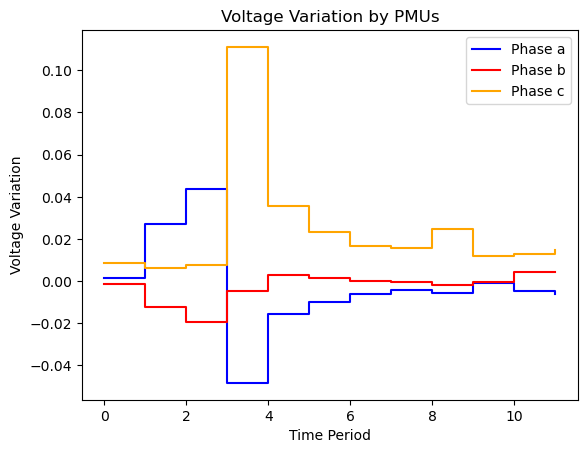

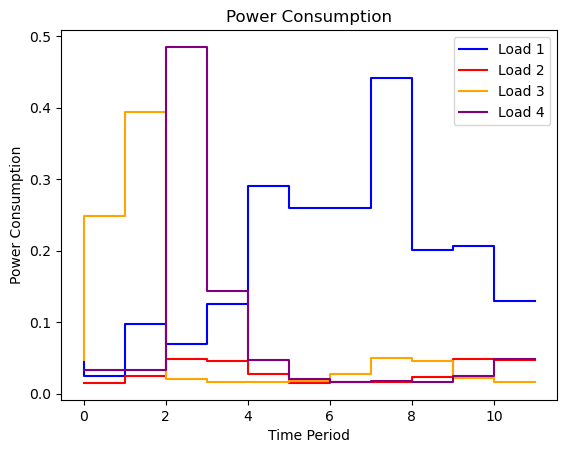

In [390]:
import matplotlib.pyplot as plt

# Specify the data to plot
x = np.arange(m)
y1 = dv_abs
y2 = s[0:12,:]


# Graph 1
plt.figure()
plt.title("Voltage Variation by PMUs")
plt.step(x, y1[:, 0], color='blue', where='post', label='Phase a')
plt.step(x, y1[:, 1], color='red',where='post', label='Phase b')
plt.step(x, y1[:, 2], color='orange', where='post',label='Phase c')
plt.xlabel("Time Period")
plt.ylabel("Voltage Variation")
plt.legend()
plt.show()

# Graph 2
plt.figure()
plt.title("Power Consumption")
plt.step(x, y2[:, 0], color='blue', label='Load 1')
plt.step(x, y2[:, 1], color='red', label='Load 2')
plt.step(x, y2[:, 2], color='orange', label='Load 3')
plt.step(x, y2[:, 3], color='purple', label='Load 4')
plt.xlabel("Time Period")
plt.ylabel("Power Consumption")
plt.legend()
plt.show()

# Show the plots
plt.show()

In [391]:
"""
import numpy as np

def add_intermittent_loads(X, p_intermittent=0.2, scale_factor=0.5):
    X_intermittent = X.copy()
    num_customers, num_periods = X.shape
    num_intermittent = int(p_intermittent * num_customers)
    
    for i in range(num_intermittent):
        customer_idx = np.random.randint(num_customers)
        time_idx = np.random.randint(num_periods)
        X_intermittent[customer_idx, time_idx] += scale_factor * X[customer_idx, time_idx]
    
    return X_intermittent

X_intermittent = add_intermittent_loads(X)

# Now, use X_intermittent in the phase identification process and compare the results with the original X.

"""

'\nimport numpy as np\n\ndef add_intermittent_loads(X, p_intermittent=0.2, scale_factor=0.5):\n    X_intermittent = X.copy()\n    num_customers, num_periods = X.shape\n    num_intermittent = int(p_intermittent * num_customers)\n    \n    for i in range(num_intermittent):\n        customer_idx = np.random.randint(num_customers)\n        time_idx = np.random.randint(num_periods)\n        X_intermittent[customer_idx, time_idx] += scale_factor * X[customer_idx, time_idx]\n    \n    return X_intermittent\n\nX_intermittent = add_intermittent_loads(X)\n\n# Now, use X_intermittent in the phase identification process and compare the results with the original X.\n\n'

# Extra Challenges

## $\cdot$ Intermittent loads:
The idea behind this extra Challenge is to introduce intermittent loads to the dataset, simulating real-world scenarios where the consumption pattern is not constant. In a practical smart grid, customers may have varying energy consumption levels throughout the day due to various factors such as appliance usage, weather conditions, or personal habits. By incorporating these intermittent loads into the dataset, we can examine how well the phase identification algorithm performs under more realistic conditions.

X changed with the intermittent loads? R: True


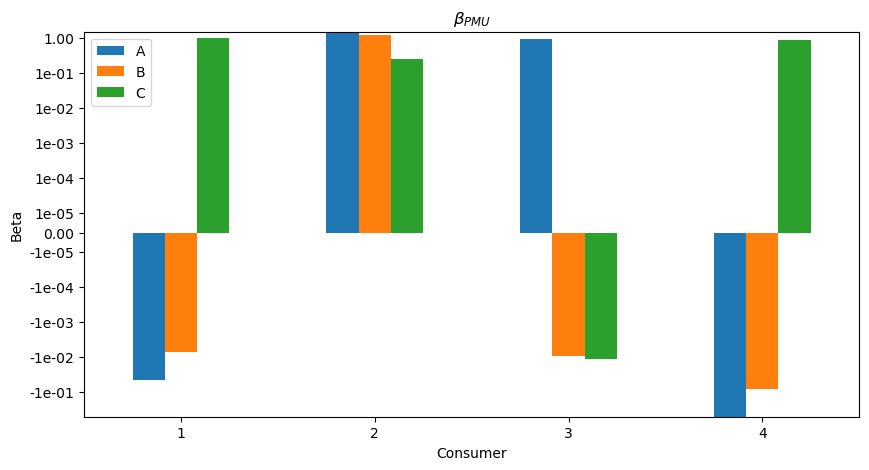

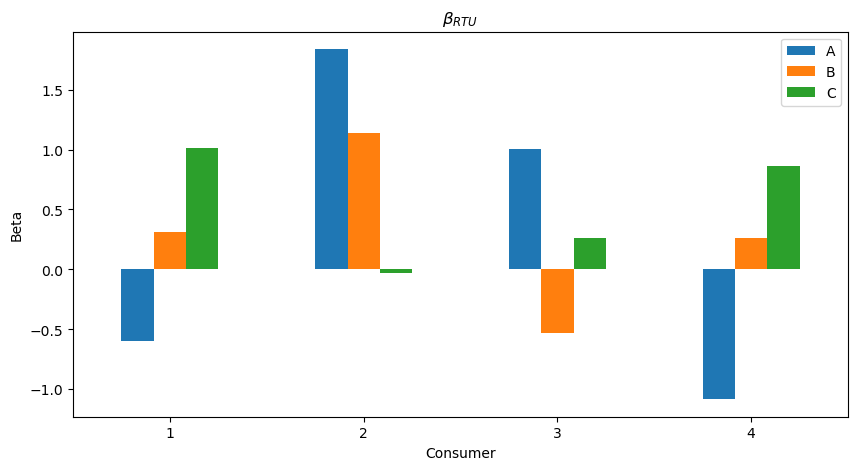

The phases of the consumers are:
PMU:  ['c', 'b', 'a', 'c']
RTU:  ['c', 'b', 'a', 'c']


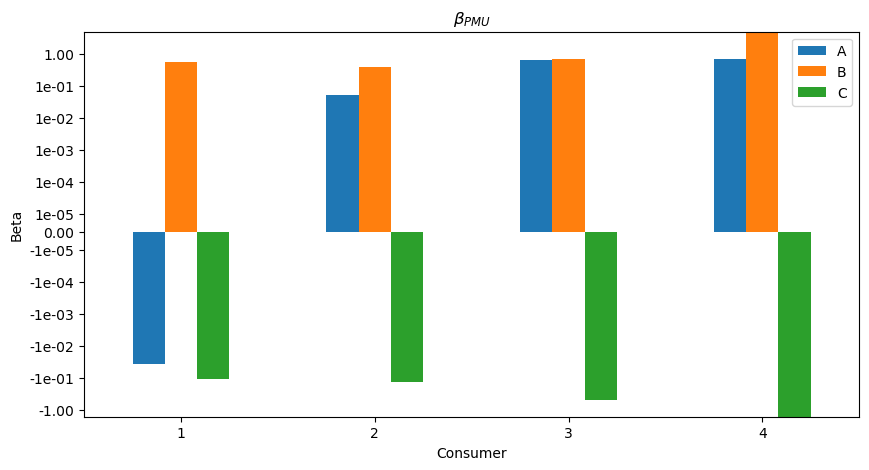

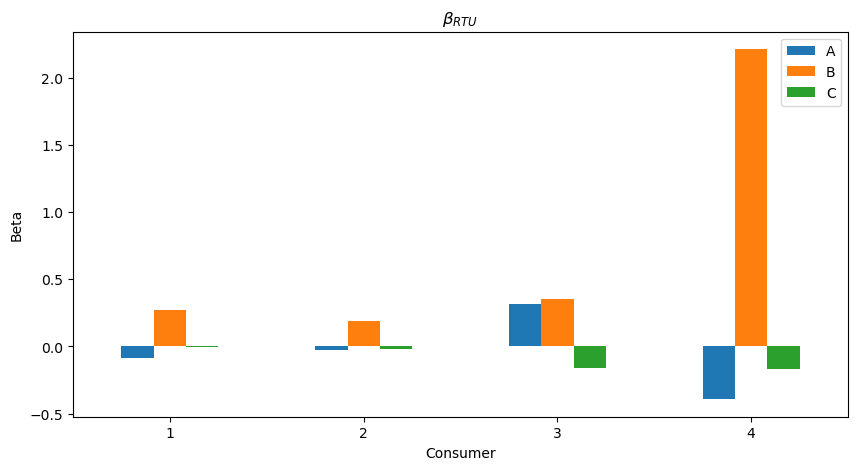

The phases of the consumers are:
PMU:  ['b', 'b', 'b', 'a']
RTU:  ['b', 'b', 'b', 'c']


In [392]:

def add_intermittent_loads(X, p_intermittent, scale_factor):
    X_intermittent = X.copy()
    num_customers, num_periods = X.shape
    num_intermittent = int(p_intermittent * num_customers)
    
    for i in range(num_intermittent):
        # set the random seed
        np.random.seed(2249)
        customer_idx = np.random.randint(num_customers)
        time_idx = np.random.randint(num_periods)
        X_intermittent[customer_idx, time_idx] += scale_factor * X[customer_idx, time_idx]
    
    return X_intermittent

X_intermittent = add_intermittent_loads(X,p_intermittent=0.2, scale_factor=2)

print("X changed with the intermittent loads? R:", np.any(X_intermittent != X))

# Now, use X_intermittent in the phase identification process and compare the results with the original X.
summarize_phase_id(X_intermittent,vz,vz_abs)

# solve using ridge regression



summarize_phase_id_ridge(X_intermittent,vz,vz_abs,0.01)




### Handling missing data.

Number of missing entries: 18
MAE: 0.005055217744372121


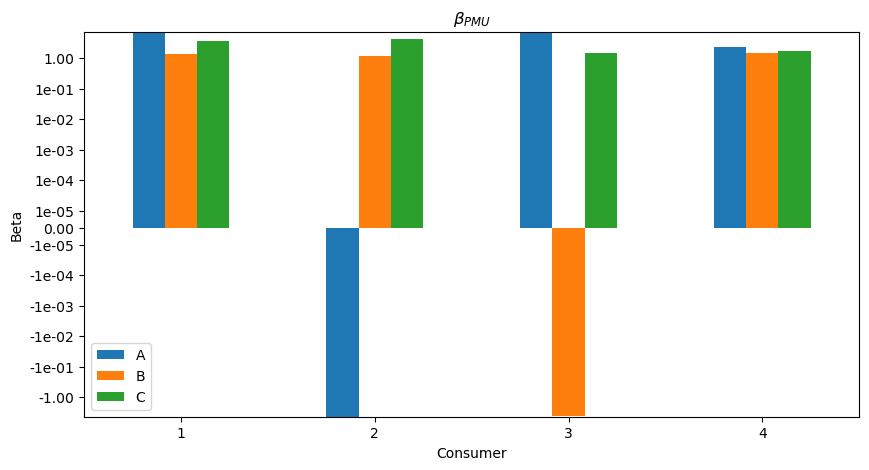

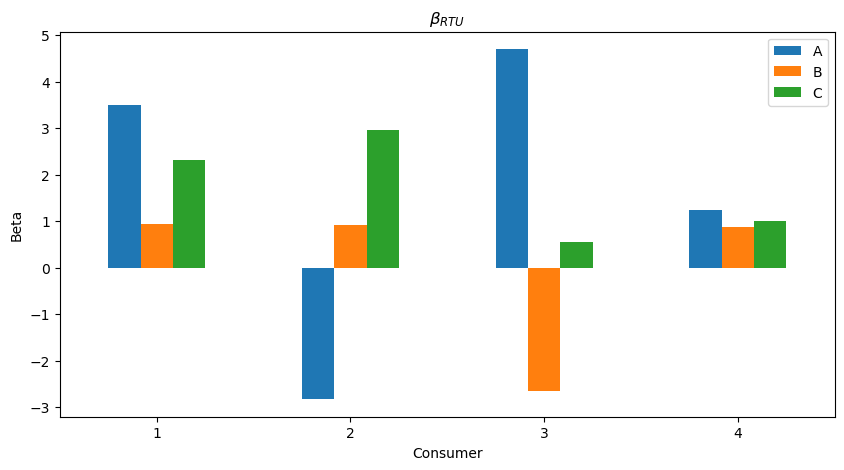

The phases of the consumers are:
PMU:  ['b', 'b', 'c', 'b']
RTU:  ['b', 'b', 'c', 'c']


In [393]:
import numpy as np
from sklearn.impute import KNNImputer

# define the percentage of missing data
missing_pct = 0.05

X_gonna_be_missing = X.copy()

X_old = X.copy()

# create a complex valued matrix X
# X = np.random.randn(10, 5) + 1j*np.random.randn(10, 5)

# create a mask for missing values
mask = np.random.rand(*X.shape) < missing_pct

# create a copy of X with missing values
X_missing = X_gonna_be_missing.copy()
X_missing[mask] = np.nan

# quantifying how many entries are missing
num_missing = np.sum(np.isnan(X_missing))
print("Number of missing entries:", num_missing)


# impute missing values using median
X_imputed = np.nanmedian(X_missing, axis=0)
X_imputed = np.broadcast_to(X_imputed, X.shape)

# compute the MAE of the imputation
mae = np.abs(X_old - X_imputed).mean()

print("MAE:", mae)

summarize_phase_id(X_imputed,vz,vz_abs)


In [394]:
X_imputed.shape

(36, 12)

In [395]:
import numpy as np
from sklearn.impute import KNNImputer

# set random seed for reproducibility
np.random.seed(42)

# generate random data
#vz = np.random.rand(1, 36)
#X = np.random.rand(36, 12)
X_old = X.copy()

# simulate missing data
percent_missing = 0.5  # change this to control the percentage of missing data
n_missing = int(X.size * percent_missing)
missing_indices = np.random.choice(X.size, n_missing, replace=False)
X.ravel()[missing_indices] = np.nan


# perform kNN imputation
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)

# print the distance to the matrix X
print("Distance to the original matrix X:")
print(np.linalg.norm(X_old - X_imputed))



def calculate_mae(true_values, imputed_values):
    mae = np.mean(np.abs(true_values - imputed_values))
    return mae

print("MAE:", calculate_mae(X_old, X_imputed))


summarize_phase_id(X_imputed,vz,vz_abs)



ValueError: Complex data not supported
[[            nan+0.j         -7.53607104e-05-0.00125553j
              nan+0.j                     nan+0.j
  -7.90385683e-05-0.0010369j              nan+0.j
              nan+0.j                     nan+0.j
  -2.68984582e-03+0.00183895j             nan+0.j
              nan+0.j         -3.42808611e-03+0.00230762j]
 [ 1.12500000e-03+0.0005625j  -1.50721421e-04-0.00251106j
  -1.04963929e-03+0.00069303j             nan+0.j
              nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j
  -2.68984582e-03+0.00183895j  3.71250000e-03+0.001815j
              nan+0.j                     nan+0.j        ]
 [            nan+0.j                     nan+0.j
              nan+0.j          9.37500000e-04+0.00045j
  -7.90385683e-05-0.0010369j              nan+0.j
              nan+0.j                     nan+0.j
  -5.37969164e-03+0.0036779j              nan+0.j
  -2.84413892e-04-0.00412262j -6.85617222e-03+0.00461524j]
 [            nan+0.j                     nan+0.j
  -5.83132939e-04+0.00038502j             nan+0.j
  -7.90385683e-05-0.0010369j  -8.58461432e-04+0.0005869j
              nan+0.j         -1.30677100e-03-0.01714339j
  -1.41932290e-02+0.00970339j             nan+0.j
              nan+0.j         -3.42808611e-03+0.00230762j]
 [ 6.25000000e-04+0.0003125j  -8.37341226e-05-0.00139503j
  -5.83132939e-04+0.00038502j  9.37500000e-04+0.00045j
  -1.58077137e-04-0.0020738j  -8.58461432e-04+0.0005869j
   1.55000000e-02+0.00744j                nan+0.j
              nan+0.j                     nan+0.j
  -5.68827784e-04-0.00824524j             nan+0.j        ]
 [            nan+0.j         -4.18670613e-05-0.00069752j
  -1.16626588e-03+0.00077003j             nan+0.j
  -7.90385683e-05-0.0010369j  -1.71692286e-03+0.0011738j
              nan+0.j         -1.30677100e-03-0.01714339j
              nan+0.j                     nan+0.j
              nan+0.j         -6.85617222e-03+0.00461524j]
 [            nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j
  -2.25489203e-02+0.01541588j             nan+0.j
              nan+0.j                     nan+0.j        ]
 [            nan+0.j         -3.24888396e-04-0.00541272j
  -2.26255580e-03+0.00149386j  1.56250000e-03+0.00075j
  -2.63461894e-04-0.00345633j             nan+0.j
              nan+0.j         -4.15215945e-03-0.05447175j
              nan+0.j                     nan+0.j
              nan+0.j         -3.42808611e-03+0.00230762j]
 [            nan+0.j                     nan+0.j
  -4.52511160e-03+0.00298772j  1.56250000e-03+0.00075j
  -1.31730947e-04-0.00172816j             nan+0.j
   2.46250000e-02+0.01182j                nan+0.j
              nan+0.j          3.71250000e-03+0.001815j
  -2.84413892e-04-0.00412262j -6.85617222e-03+0.00461524j]
 [            nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j
  -2.58192656e-04-0.0033872j              nan+0.j
              nan+0.j         -1.05384758e-04-0.00138253j
              nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j        ]
 [ 1.75000000e-03+0.000875j   -2.34455543e-04-0.00390609j
              nan+0.j                     nan+0.j
              nan+0.j         -2.80430734e-03+0.0019172j
              nan+0.j         -2.10769515e-04-0.00276506j
  -1.14461524e-03+0.00078253j  5.45625000e-02+0.026675j
  -8.36004471e-03-0.12118002j             nan+0.j        ]
 [            nan+0.j         -1.17227772e-04-0.00195304j
  -3.26554446e-03+0.00215609j  3.06250000e-03+0.00147j
  -2.58192656e-04-0.0033872j              nan+0.j
   1.25000000e-03+0.0006j                 nan+0.j
              nan+0.j                     nan+0.j
  -4.18002235e-03-0.06059001j             nan+0.j        ]
 [            nan+0.j                     nan+0.j
  -2.91566469e-03+0.00192508j             nan+0.j
              nan+0.j         -2.63261506e-03+0.00179982j
              nan+0.j         -8.43078062e-05-0.00110603j
              nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j        ]
 [ 3.12500000e-03+0.0015625j              nan+0.j
              nan+0.j          2.87500000e-03+0.00138j
  -4.84769886e-04-0.00635965j -2.63261506e-03+0.00179982j
   1.00000000e-03+0.00048j                nan+0.j
  -9.15692194e-04+0.00062603j             nan+0.j
  -2.46492040e-03-0.03572937j             nan+0.j        ]
 [            nan+0.j         -2.09335307e-04-0.00348758j
  -5.83132939e-03+0.00385016j  2.87500000e-03+0.00138j
              nan+0.j                     nan+0.j
   1.00000000e-03+0.00048j                nan+0.j
              nan+0.j                     nan+0.j
  -1.23246020e-03-0.01786468j -2.97100796e-02+0.01999937j]
 [            nan+0.j                     nan+0.j
  -6.76434209e-03+0.00446618j  3.37500000e-03+0.00162j
              nan+0.j         -1.54523058e-03+0.00105642j
   2.00000000e-03+0.00096j    -8.43078062e-05-0.00110603j
  -9.15692194e-04+0.00062603j  1.05750000e-02+0.00517j
  -4.05074331e-04-0.00587161j -4.88242567e-03+0.00328661j]
 [            nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j
              nan+0.j         -1.54523058e-03+0.00105642j
              nan+0.j                     nan+0.j
  -9.15692194e-04+0.00062603j  5.28750000e-03+0.002585j
              nan+0.j                     nan+0.j        ]
 [            nan+0.j         -4.85657911e-04-0.00809118j
  -1.35286842e-02+0.00893237j  1.68750000e-03+0.00081j
              nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j
  -1.83138439e-03+0.00125205j  5.28750000e-03+0.002585j
  -4.05074331e-04-0.00587161j -9.76485134e-03+0.00657322j]
 [ 1.29500000e-02+0.006475j   -4.33742755e-04-0.00722626j
              nan+0.j          1.87500000e-03+0.0009j
  -7.90385683e-05-0.0010369j  -8.58461432e-04+0.0005869j
              nan+0.j         -8.95770441e-05-0.00117515j
  -9.72922956e-04+0.00066515j             nan+0.j
  -1.72372056e-04-0.00249856j             nan+0.j        ]
 [ 6.47500000e-03+0.0032375j              nan+0.j
  -6.04125724e-03+0.00398876j             nan+0.j
  -1.58077137e-04-0.0020738j  -8.58461432e-04+0.0005869j
   1.06250000e-03+0.00051j    -1.79154088e-04-0.0023503j
  -9.72922956e-04+0.00066515j             nan+0.j
              nan+0.j                     nan+0.j        ]
 [ 6.47500000e-03+0.0032375j  -4.33742755e-04-0.00722626j
  -1.20825145e-02+0.00797753j  9.37500000e-04+0.00045j
  -7.90385683e-05-0.0010369j              nan+0.j
              nan+0.j                     nan+0.j
              nan+0.j          2.25000000e-03+0.0011j
              nan+0.j         -4.15525589e-03+0.00279711j]
 [ 1.29500000e-02+0.006475j               nan+0.j
  -6.04125724e-03+0.00398876j             nan+0.j
  -8.43078062e-05-0.00110603j -9.15692194e-04+0.00062603j
   3.50000000e-03+0.00168j    -1.47538661e-04-0.00193554j
  -1.60246134e-03+0.00109554j             nan+0.j
              nan+0.j         -1.66210236e-03+0.00111885j]
 [ 6.47500000e-03+0.0032375j  -8.67485510e-04-0.01445253j
              nan+0.j          1.00000000e-03+0.00048j
  -1.68615612e-04-0.00221205j -9.15692194e-04+0.00062603j
   1.75000000e-03+0.00084j                nan+0.j
              nan+0.j          1.80000000e-03+0.00088j
              nan+0.j                     nan+0.j        ]
 [ 6.47500000e-03+0.0032375j              nan+0.j
              nan+0.j          1.00000000e-03+0.00048j
              nan+0.j         -1.83138439e-03+0.00125205j
   1.75000000e-03+0.00084j    -1.47538661e-04-0.00193554j
              nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j        ]
 [ 2.21000000e-02+0.01105j                nan+0.j
  -1.03097904e-02+0.00680708j             nan+0.j
  -8.43078062e-05-0.00110603j -9.15692194e-04+0.00062603j
   6.25000000e-03+0.003j      -2.63461894e-04-0.00345633j
              nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j        ]
 [ 1.10500000e-02+0.005525j   -1.48041929e-03-0.02466416j
              nan+0.j          1.00000000e-03+0.00048j
              nan+0.j         -9.15692194e-04+0.00062603j
   3.12500000e-03+0.0015j     -5.26923789e-04-0.00691266j
  -2.86153811e-03+0.00195633j  1.91250000e-03+0.000935j
              nan+0.j         -1.76598375e-03+0.00118877j]
 [            nan+0.j         -7.40209644e-04-0.01233208j
  -2.06195807e-02+0.01361416j  1.00000000e-03+0.00048j
              nan+0.j                     nan+0.j
              nan+0.j         -2.63461894e-04-0.00345633j
              nan+0.j          1.91250000e-03+0.000935j
              nan+0.j         -3.53196751e-03+0.00237755j]
 [ 1.00500000e-02+0.005025j               nan+0.j
  -4.68838883e-03+0.00309553j  2.87500000e-03+0.00138j
  -1.21192471e-04-0.00158991j -1.31630753e-03+0.00089991j
   5.75000000e-03+0.00276j    -2.42384943e-04-0.00317982j
              nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j        ]
 [ 5.02500000e-03+0.0025125j  -6.73222346e-04-0.01121606j
  -4.68838883e-03+0.00309553j  1.43750000e-03+0.00069j
  -2.42384943e-04-0.00317982j             nan+0.j
              nan+0.j         -4.84769886e-04-0.00635965j
  -2.63261506e-03+0.00179982j  1.80000000e-03+0.00088j
              nan+0.j                     nan+0.j        ]
 [ 5.02500000e-03+0.0025125j  -3.36611173e-04-0.00560803j
  -9.37677765e-03+0.00619106j             nan+0.j
              nan+0.j         -2.63261506e-03+0.00179982j
   2.87500000e-03+0.00138j                nan+0.j
              nan+0.j                     nan+0.j
  -1.37897645e-04-0.00199885j -3.32420471e-03+0.00223769j]
 [            nan+0.j                     nan+0.j
              nan+0.j          6.12500000e-03+0.00294j
  -2.58192656e-04-0.0033872j  -2.80430734e-03+0.0019172j
   2.75000000e-03+0.00132j                nan+0.j
  -1.25907677e-03+0.00086078j             nan+0.j
  -2.06846467e-04-0.00299827j -2.49315353e-03+0.00167827j]
 [ 5.15000000e-03+0.002575j               nan+0.j
              nan+0.j          3.06250000e-03+0.00147j
  -5.16385313e-04-0.00677441j -2.80430734e-03+0.0019172j
              nan+0.j                     nan+0.j
  -1.25907677e-03+0.00086078j             nan+0.j
              nan+0.j                     nan+0.j        ]
 [            nan+0.j         -3.44984585e-04-0.00574753j
  -9.61003083e-03+0.00634506j  3.06250000e-03+0.00147j
  -2.58192656e-04-0.0033872j              nan+0.j
              nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j
              nan+0.j         -4.98630707e-03+0.00335654j]
 [ 6.50000000e-03+0.00325j    -2.17708719e-04-0.00362708j
  -3.03229128e-03+0.00200208j             nan+0.j
              nan+0.j                     nan+0.j
              nan+0.j                     nan+0.j
              nan+0.j          1.10250000e-02+0.00539j
              nan+0.j         -5.09018846e-03+0.00342647j]
 [            nan+0.j                     nan+0.j
  -3.03229128e-03+0.00200208j  2.93750000e-03+0.00141j
              nan+0.j                     nan+0.j
              nan+0.j         -1.68615612e-04-0.00221205j
  -9.15692194e-04+0.00062603j  5.51250000e-03+0.002695j
              nan+0.j         -5.09018846e-03+0.00342647j]
 [            nan+0.j                     nan+0.j
  -6.06458256e-03+0.00400417j             nan+0.j
              nan+0.j         -5.37969164e-03+0.0036779j
              nan+0.j                     nan+0.j
              nan+0.j          5.51250000e-03+0.002695j
  -4.22311537e-04-0.00612147j -1.01803769e-02+0.00685293j]]


In [ ]:
# print their shapes
print("Shape of X:", X.shape)
print("Shape of X_imputed:", X_imputed.shape)

Shape of X: (36, 12)


NameError: name 'X_imputed' is not defined

## $\cdot$ Clustering (KMeans)

In [ ]:
from sklearn.cluster import KMeans

def cluster_phase_identification(X, vz, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    
    phase_labels = np.empty(X.shape[0], dtype=np.int32)
    for i, label in enumerate(cluster_labels):
        phase_labels[i] = np.argmax(vz[:, label])
    
    return phase_labels

#phase_labels = cluster_phase_identification(X, vz)


## Estimating impedances.

In [ ]:
print(Volt.shape,s.shape)
print(Volt.shape,s[:-1,:].shape)

(12, 3) (13, 4)
(12, 3) (12, 4)


In [ ]:
import numpy as np
from scipy.optimize import least_squares

# Load data
V_measured = Volt  # Load voltage measurements from the dataset
I = s[:-1,:]  # Load current values from the dataset

# Define the objective function
def objective(Z, V_measured, I):
    Z_matrix = Z.reshape(n, n)  # Reshape the impedance vector into a matrix
    V_calculated = np.dot(I, Z_matrix)
    return (V_measured - V_calculated).flatten()

# Set initial guess for Z
n = len(I)
Z_init = np.random.rand(n * n)

# Solve the optimization problem
result = least_squares(objective, Z_init, args=(V_measured, I))

# Extract the estimated impedance matrix
Z_estimated = result.x.reshape(n, n)


ValueError: shapes (12,4) and (12,12) not aligned: 4 (dim 1) != 12 (dim 0)